In [1]:
import ee
import geemap
import os
import numpy as np
import matplotlib.pyplot as plt

In [11]:
! pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.3 MB/s eta 0:00:00


In [19]:
! pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.2 MB/s eta 0:00:00


In [2]:
ee.Authenticate()
ee.Initialize(project='ee-rupesh32003')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [3]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [22]:
features = Map.draw_features
print(features)
roi = ee.FeatureCollection(features).geometry()
print(roi)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection",
          "arguments": {
            "features": {
              "arrayValue": {
                "values": [
                  {
                    "functionInvocationValue": {
                      "functionName": "Feature",
                      "arguments": {
                        "geometry": {
                          "functionInvocationValue": {
                            "functionName": "GeometryConstructors.Polygon",
                            "arguments": {
                              "coordinates": {
                                "constantValue": [
                                  [
                                    [
                                      72.774811,
                                      18.884199
                                    ],
          

In [4]:
point = ee.Geometry.Point(-3.83502, 40.40595);
start = ee.Date('2019-07-01');
finish = ee.Date('2019-07-31');

# Filter a image from the landsat raw images collection, using bounds, date, and selecting the image with the least cloud cover
img = ee.ImageCollection('LANDSAT/LC08/C02/T1') \
            .filterBounds(point) \
            .filterDate(start, finish) \
            .sort('CLOUD_COVER', True) \
            .first()

# Select the corresponding bands for the multiespectral and panchromatic image
img_multi = img.select(['B4', 'B3', 'B2'])
img_pan = img.select(['B8'])

# Display the images on the map
Map.addLayer(img_pan)
Map.addLayer(img_multi)


# Center the map
Map.setCenter(-3.83502, 40.40595, 8)
Map

Map(center=[40.40595, -3.83502], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [5]:
# feature to extract
# roi = ee.Geometry.Polygon([
#   [[-4.547875, 39.766127], [-4.547875, 40.551179], [-2.960148, 40.551179], [-2.960148, 39.766127], [-4.547875, 39.766127]]
# ]);

features = Map.draw_features
roi = ee.FeatureCollection(features).geometry()

# add the polygon to the map
Map.addLayer(roi, {}, 'feature');

print('Polygon coordinates >>', roi.getInfo().get('coordinates'))

Polygon coordinates >> [[[-3.651581, 40.397287], [-3.651581, 40.557635], [-3.387909, 40.557635], [-3.387909, 40.397287], [-3.651581, 40.397287]]]


In [6]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
filename_xs = os.path.join(out_dir, 'landsat_multi.tif')
filename_pan = os.path.join(out_dir, 'landsat_pan.tif')

In [8]:
try:
    #geemap.ee_export_image(img_multi, filename=filename_xs, region=roi, file_per_band=False)
    geemap.ee_export_image(img_pan, filename=filename_pan, region=roi, file_per_band=False)
except Exception as e:
    print(f"An error occurred: {e}")
    print(f"Response content: {e.response.content.decode() if hasattr(e, 'response') and hasattr(e.response, 'content') else 'N/A'}") # Added error diagnostics

Generating URL ...
Please wait ...
An error occurred while downloading.
An error occurred: Expecting value: line 1 column 1 (char 0)
Response content: N/A


In [ ]:
import os
import sys
import gc
import numpy as np
import warnings as warn
import argparse
import subprocess
import pywt
from osgeo import osr, gdal, gdalconst

class pansharpen(object):

  def __init__(self,outputDirectory,red,green,blue,pan,NIR=None):
    '''function __init__(self,pan,multi):
    This is a constructor method to create an object of this class.
    Instantiate an object of this class with 4 or 5 input NumPy arrays
    holding data for the following bands of a satellite image:
      (1) Red band
      (2) Green band
      (3) blue band
      (4) panchromatic band (grey-scale)
      (5) NIR band , near-infrared band (optional)
    Returns:
      pancharpen: an object of the pansharpen class.
    '''
    self.outDir = outputDirectory
    self.red = red
    self.green = green
    self.blue = blue
    self.pan = pan

    if not NIR is None:
      self.NIR = NIR
    else:
      self.NIR = None

  def pansharpenPCA(self):
    '''function pansharpenPCA(self):
    This is an instance method that returns a Python list of 3 or 4
    NumPy arrays containing the pan-sharpened Red,Green,Blue, and
    optionally, NIR bands. These bands will have been created using
    the principal component analysis (PCA) pan-sharpening.

    Returns:
      list: Python list[] containing 3 or 4 NumPy arrays using PCA method.
    '''
    nrows,ncols = self.pan.shape
    if self.NIR is not None:
      image = np.zeros( (nrows,ncols,4),dtype=np.float32)
      image[:,:,0] = self.red
      image[:,:,1] = self.green
      image[:,:,2] = self.blue
      image[:,:,3] = self.NIR
    else:
      image = np.zeros( (nrows,ncols,3) , dtype=np.float32)
      image[:,:,0] = self.red
      image[:,:,1] = self.green
      image[:,:,2] = self.blue

    m,n,d=image.shape
    nanlocs = np.where(self.pan==0.0)
    image   = np.where( image == 0.0, np.nan, image )
    image   = np.ma.array(image, mask=np.isnan(image))

    M = np.reshape( image, (m*n,d))
    [ PCAData , PCAMap ] = pansharpen.multiPCA( M,d )
    PCAData = np.reshape( PCAData , (m,n,d))
    F = PCAData

    P = ( self.pan - self.pan.mean() ) * (np.std(F) / self.pan.std() )  + F.mean()
    F[:,:,0] = P
    F = pansharpen.inversePCA( PCAMap['M'] , np.reshape( F, (m*n,d)), PCAMap['mean'])
    sharpened = np.reshape(F,(m,n,d))

    outred   = sharpened[ :,:,0 ]
    outgreen = sharpened[ :,:,1 ]
    outblue  = sharpened[ :,:,2 ]

    if self.NIR is not None:
      outNIR = sharpened[ :,:,3 ]
      return [ outred, outgreen, outblue, outNIR ]
    else:
      return [ outred, outgreen, outblue ]

  @staticmethod
  def inversePCA( E,P,MeanV ):
    m,n = P.shape
    dim = MeanV.shape[0]
    M   = np.zeros((m,dim))

    for k in range(0,dim):  M[ 0:m, k  ] = MeanV[k]
    return np.ma.dot( P, E.T ) + M

  @staticmethod
  def multiPCA( X , no_dims=None ):
    '''
    function multiPCA( X, no_dims=None):
    This function does necessary computations as part of the
    principal component analysis (PCA) pan-sharpening method.

    Args:
      X (numpy.ndarray): 3 or 4-layer data cube (3D numpy array).
      no_dims (int): number of dimensions. Default is 2.
    '''
    # create output dictionary to hold PCA results
    X = np.where( X == 0.0 , np.nan, X)
    X = np.ma.array( X , mask=np.isnan(X))
    mapping = {}

    # establish dims. if not passed-in as argument
    if no_dims is None:
      no_dims = 2

    mapping['mean'] = np.ma.mean( X , axis=0)
    X = X - np.tile( mapping['mean'] , (X.shape[0] , 1 )   )

    # compute covariance matrix
    if X.shape[1] < X.shape[0]:
      C = np.ma.cov( X , rowvar=False)
    else:
      C = ( 1 / X.shape[0] ) * np.dot( X , X.T )

    # perform eigenvalue decomposition of C
    C[np.isnan(C)] = 0
    C[np.isinf(C)] = 0

    eigenvalues,M = np.linalg.eigh( C, UPLO='U')
    ind     = np.arange( 0 , eigenvalues.shape[0] , 1)
    ind     = np.flip(ind)

    if no_dims > M.shape[1]: # second axis
      no_dims =  M.shape[1]

    M = M[:,ind[0:no_dims]]
    eigenvalues = eigenvalues[0:no_dims]

    if not ( X.shape[1] < X.shape[0] ):
      with warn.catch_warnings():
        warn.filterwarnings('ignore',category=RuntimeWarning)
        M = np.dot(X.T,M) * np.tile(  (1.0 / np.sqrt( X.shape[0] * eigenvalues )).T , ( X.shape[1], 1))

    mappedX  = np.ma.dot( X , M )
    mapping['M']       = M
    mapping['lambda']  = eigenvalues
    return [ mappedX, mapping ]


  @staticmethod
  def writeMultispectralGeotiff( arrays,dsmulti,outname ):
    '''function writeMultispectralGeotiff( arrays,dsmulti,outname ):
    This function writes out a multispectral Geotiff (3 or 4 bands)
    containing the Red,Green,Blue, and optionally, NIR bands. This
    data should be passed into this function as a list[] of NumPy
    arrays with 3 or 4 arrays. This function also takes in a GDAL
    dataset object (dsmulti), which should have been created during
    the running of this command-line program.

    Args:
      arrays (list): Python list[] holding Red,Green,Blue,NIR bands.
      dsmulti (osgeo.gdal.Dataset): GDAL dataset object for multispectral Geotiff.
      outname (str): output Geotiff filename.
    '''

    # if the multispectal geotiff already exists, delete it.
    if os.path.isfile(outname):
      os.remove(outname)

    # write the multispectral geotiff
    nrows,ncols = arrays[0].shape
    driv = gdal.GetDriverByName('GTiff')
    dst = driv.Create( outname, ncols, nrows, len(arrays), gdal.GDT_Float32)
    dst.SetGeoTransform(dsmulti.GetGeoTransform())
    dst.SetProjection(dsmulti.GetProjection())

    # ------------------------------------------------------------------
    # in this method, we expect python list[] of 3 or 4 NumPy arrays,
    # in the following order:
    #   (1) Red
    #   (2) Green
    #   (3) Blue
    #   (4) NIR (optional)
    # and we write the multispectral (multiband) geotiff with bands
    # in the same order.
    # ------------------------------------------------------------------

    dst.GetRasterBand(1).WriteArray( arrays[0] )
    dst.GetRasterBand(2).WriteArray( arrays[1] )
    dst.GetRasterBand(3).WriteArray( arrays[2] )

    if len( arrays )>3:
      dst.GetRasterBand(4).WriteArray( arrays[3] )

    dst=None
    del dst

  @staticmethod
  def resample( srcImageFilename, sourceDataset, dstDataset, outname, interp ):
    '''function resample( srcImageFilename,sourceDataset,dstDataset,outname,interp):
    This function resamples a low-resolution multispectral Geotiff to larger
    dimensions by means of the "interp" method (i.e. gdalconst.GRA_Cubic) passed
    into this function. Ultimately, this function resamples or resizes the
    multispectral geotiff dataset, referred to by "sourceDataset" (and srcImageFilename)
    to the same dimensions as the panchromatic Geotiff image Geotiff file by
    means of an interpolation method (i.e. bicubic resampling).

    Args:
      srcImageFilename (str): source (low-res.) multispectral Geotiff filename.
      sourceDataset (osgeo.gdal.Dataset): input multispectral GDAL dataset object.
      dstDataset (osgeo.gdal.Dataset): destination (high-res.) panchromatic dataset object.
      outname (str): name of outputted resampled Geotiff
      interp (int): GDAL interpolation method (i.e. gdalconst.GRA_Cubic)
    '''

    # get the "source" (i.e. low-res. multispectral) projection and geotransform
    srcProjection   = sourceDataset.GetProjection()
    srcGeotransform = sourceDataset.GetGeoTransform()
    srcNumRasters   = sourceDataset.RasterCount
    dstProjection   = dstDataset.GetProjection()
    dstGeotransform = dstDataset.GetGeoTransform()
    nrows           = dstDataset.RasterYSize
    ncols           = dstDataset.RasterXSize
    dst_fn          = outname

    # if the resampled-multispectral (3 or 4 band) Geotiff image file exists, delete it.
    if not os.path.isfile(outname):
      dst_ds = gdal.GetDriverByName('GTiff').Create( dst_fn, ncols,nrows,srcNumRasters,gdalconst.GDT_Float32)
      dst_ds.SetGeoTransform(dstGeotransform)
      dst_ds.SetProjection(dstProjection)
      gdal.ReprojectImage(sourceDataset, dst_ds, srcProjection, dstProjection,interp)
      dst_ds=None
      del dst_ds
    return dst_fn

def main():

  multispectralGeotiff , panchromaticGeotiff = '' , ''
  parser = argparse.ArgumentParser(description='python pansharpening tool.')
  parser.add_argument('-p','--panchromatic',required=False,type=str,
    dest='panchromatic',help='panchromatic image file (1 band).')
  parser.add_argument('-m','--multispectral',required=False,type=str,
    dest='multispectral',help='multispectral image file (3 or 4 bands).')
  parser.add_argument('-v','--version',required=False,
    dest='version',help='show version.',action='store_true')
  parser.add_argument('-u','--usage',required=False,
    dest='showhelp',action='store_true',help='show help message.')
  args = parser.parse_args()

  version   = args.version
  showhelp  = args.showhelp
  panchromaticGeotiff  = args.panchromatic
  multispectralGeotiff = args.multispectral

  dsPan   = gdal.Open( panchromaticGeotiff , gdal.GA_ReadOnly )
  dsMulti = gdal.Open( multispectralGeotiff, gdal.GA_ReadOnly )

  if dsPan.RasterCount != 1:
    print('  \n    Panchromatic Geotiff image file: ' + panchromaticGeotiff + ' should have ONE single band. Exiting ... ')
    sys.exit(1)

  if (dsMulti.RasterCount != 3) and ( dsMulti.RasterCount != 4 ):
    print('  \n    Multispectral Geotiff image file: ' + multispectralGeotiff + ' should have 3 or 4 bands. Exiting ... ')
    sys.exit(1)

  if multispectralGeotiff.endswith('.TIF'):
    resampledMultispectralGeotiffFilename = multispectralGeotiff.replace('.TIF', '_RESAMPLED.TIF')
  elif multispectralGeotiff.endswith('.tif'):
    resampledMultispectralGeotiffFilename = multispectralGeotiff.replace('.tif', '_RESAMPLED.TIF')
  else:
    print('  \n    Multispectral Geotiff image file: ' + multispectralGeotiff + ' should have .TIF or .tif extension. Exiting ... ')
    sys.exit(1)

  resampledMultispectralGeotiffFilename = pansharpen.resample(
    multispectralGeotiff,
    dsMulti,
    dsPan,
    resampledMultispectralGeotiffFilename,
    gdalconst.GRA_Cubic
  )

  dsMulti,dsPan = None,None
  del dsMulti,dsPan

  if not os.path.isfile(resampledMultispectralGeotiffFilename):
    print('  \n    Multispectral Geotiff image file: ' + multispectralGeotiff + ' . FAILURE to resample. Exiting .... ')
    sys.exit(1)


  outnamePCA = resampledMultispectralGeotiffFilename.replace(
    '_RESAMPLED.TIF', '_panSharpenedPCA.tif')


  if os.path.isfile( outnamePCA ):
    os.remove( outnamePCA )
  else: pass

  dsPan   = gdal.Open( panchromaticGeotiff )
  dsMulti = gdal.Open( resampledMultispectralGeotiffFilename )

  outputDir = os.path.dirname( panchromaticGeotiff)
  nrows,ncols = dsPan.RasterYSize, dsPan.RasterXSize

  red   = dsMulti.GetRasterBand(1).ReadAsArray().astype(float)
  green = dsMulti.GetRasterBand(2).ReadAsArray().astype(float)
  blue  = dsMulti.GetRasterBand(3).ReadAsArray().astype(float)
  pan   = dsPan.GetRasterBand(1).ReadAsArray().astype(float)

  if dsMulti.RasterCount>3:
    NIR   = dsMulti.GetRasterBand(4).ReadAsArray().astype(float)
    imgFusion  = pansharpen( outputDir, red,green,blue,pan,NIR)
  else:
    imgFusion  = pansharpen( outputDir, red,green,blue,pan )

  sharpenedPCA     = imgFusion.pansharpenPCA()
  pansharpen.writeMultispectralGeotiff( sharpenedPCA,dsMulti,outnamePCA )
  del sharpenedPCA

  # clean-up resampled MS geotiff ... we don't need it anymore
  os.remove( resampledMultispectralGeotiffFilename )

if __name__ == '__main__':
  main()


In [29]:
! python pansharpen.py --panchromatic /content/landsat_pan.tif --multispectral /content/landsat_multi.tif

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

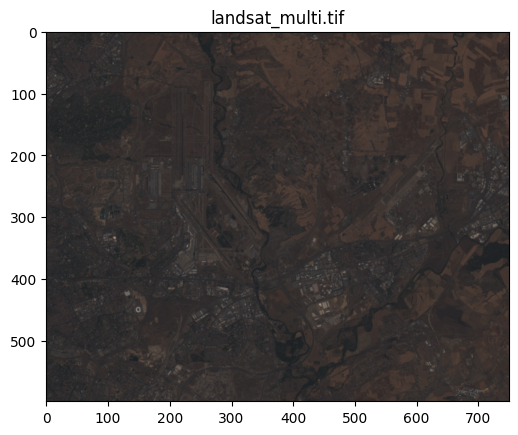

In [27]:
img_multi = mpimg.imread('/content/landsat_multi.tif')
plt.imshow(img_multi)
plt.title('landsat_multi.tif')
plt.show()

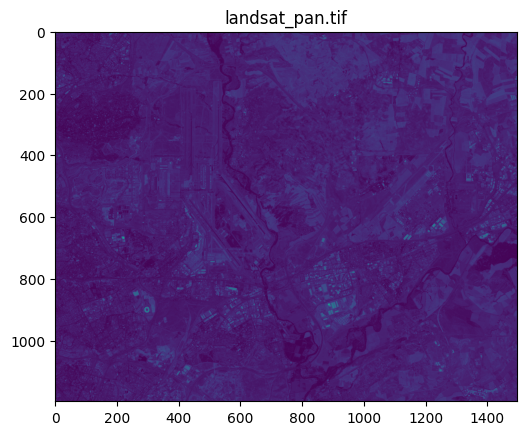

In [28]:
img_pan = mpimg.imread('/content/landsat_pan.tif')
plt.imshow(img_pan)
plt.title('landsat_pan.tif')
plt.show()

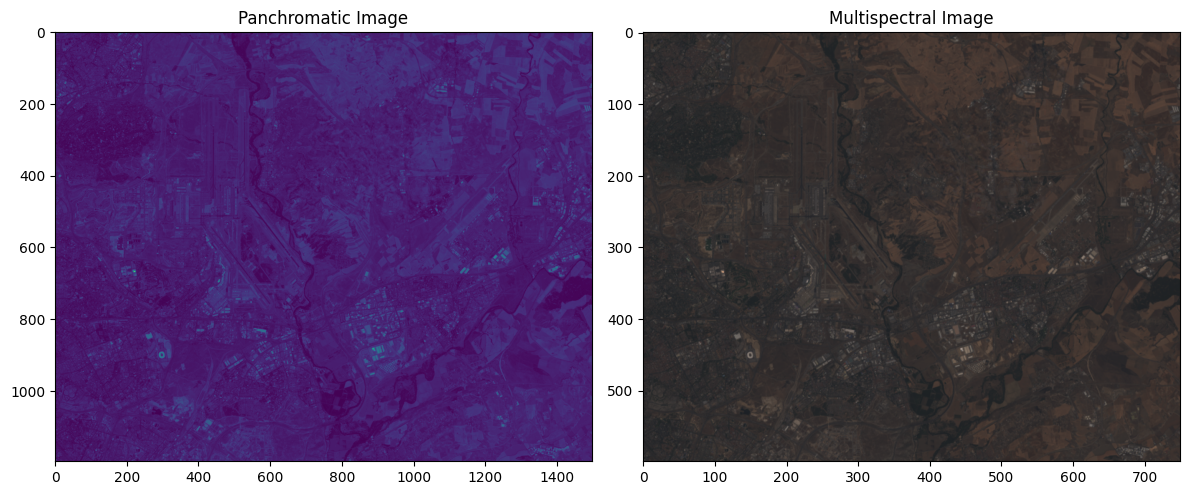

In [15]:
img_pan = mpimg.imread('/content/landsat_pan.tif')
img_multi = mpimg.imread('/content/landsat_multi.tif')

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the images
axes[0].imshow(img_pan)
axes[0].set_title('Panchromatic Image')

axes[1].imshow(img_multi)
axes[1].set_title('Multispectral Image')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

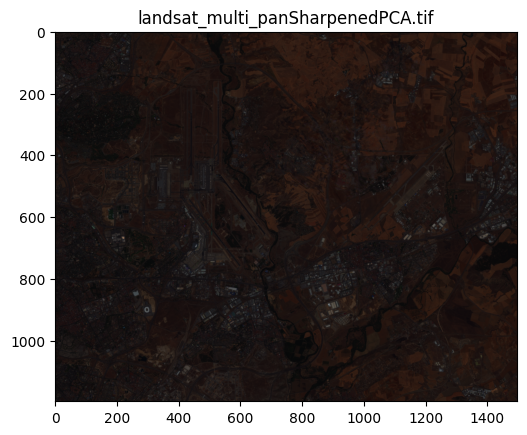

In [30]:
import matplotlib.pyplot as plt
import rasterio

# Load the image using rasterio
with rasterio.open('/content/landsat_multi_panSharpenedPCA.tif') as dataset:
    img = dataset.read()

img = np.transpose(img, (1, 2, 0))
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)
plt.title('landsat_multi_panSharpenedPCA.tif')
plt.show()